# Chicago West Nile Virus Analysis

(by Steve Gregoire)


In [8]:
import requests
import collections
import time
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib        as mtl
import statsmodels.api   as sm

import matplotlib.pyplot as plt
plt.style.use("ggplot")

from datetime                        import timedelta
from datetime                        import date
from datetime                        import datetime

############################################################
#Many custom functions are pulled from the following package
import project_4_package.project_4_data as p4
#############################################################

from sklearn.preprocessing           import StandardScaler

from sklearn.model_selection         import train_test_split
from sklearn.model_selection         import GridSearchCV

from sklearn.linear_model            import LinearRegression

from sklearn.ensemble                import BaggingClassifier
from sklearn.ensemble                import RandomForestClassifier
from sklearn.ensemble                import ExtraTreesClassifier
from sklearn.ensemble                import GradientBoostingClassifier
from sklearn.tree                    import DecisionTreeClassifier
from sklearn.neighbors               import KNeighborsClassifier
from sklearn.linear_model            import LogisticRegression

from sklearn.metrics                 import confusion_matrix
from sklearn.metrics                 import classification_report
from sklearn.metrics                 import roc_auc_score
from sklearn.metrics                 import accuracy_score
from sklearn.metrics                 import f1_score
from sklearn.model_selection         import cross_val_score

from sklearn.pipeline                import Pipeline
from sklearn.preprocessing           import LabelBinarizer

In [9]:
weather = pd.read_csv('../Assets/input/weather.csv')
train   = pd.read_csv('../Assets/input/train.csv')
test    = pd.read_csv('../Assets/input/test.csv')


process_weather(weather)
process_data(train)
process_data(test)


print('Train Rows, Columns before',train.shape)

w2 = weather[weather['Station']==1]
df = pd.merge(train,w2,on='Date',how='inner')
print('train rows after merge',df.shape)

df_test = pd.merge(test,w2,on='Date',how='inner')
print('test rows after join weather',df_test.shape)

Weather shape before: (2944, 22)
Weather shape after: (2944, 63)
Train Rows, Columns before (10506, 13)
train rows after merge (10506, 75)
test rows after join weather (116293, 74)


In [4]:
# This is the CodeSum dictionary.
dictonary = {'+FC': 'TORNADO OR WATERSPOUT',
        'FC': 'FUNNEL CLOUD',
        'TS': 'THUNDERSTORM',
        'GR': 'HAIL',
        'RA': 'RAIN',
        'DZ': 'DRIZZLE',
        'SN': 'SNOW',
        'SG': 'SNOW  GRAINS',
        'GS': 'SMALL HAIL',
        'PL':  'ICE PELLETS',
        'IC':  'ICE CRYSTALS',
        'FG+': 'HEAVY FOG',
        'FG':  'FOG',
        'BR':  'MIST',
        'UP':  'UNKNOWN PRECIPITATION',
        'HZ':  'HAZE',
        'FU':  'SMOKE',
        'VA':  'VOLCANIC ASH',
        'DU':  'WIDESPREAD DUST',
        'DS':  'DUSTSTORM',
        'PO':  'SAND or DUST WHIRLS',
        'SA':  'SAND',
        'SS':  'SANDSTORM',
        'PY':  'SPRAY',
        'SQ':  'SQUALL',
        'DR':  'LOW DRIFTING',
        'SH':  'SHOWER',
        'FZ':  'FREEZING',
        'MI':  'SHALLOW',
        'PR':  'PARTIAL',
        'BC':  'PATCHES',
        'BL':  'BLOWING',
        'VC':  'VICINITY',
        '-': 'LIGHT',
        '+':   'HEAVY',
        'NO SIGN': 'MODERATE',
        'VCTS': 'VICINITY THUNDERSTORM',
        'TSRA': 'THUNDERSTORM RAIN',
        'BCFG': 'PATCHES FOG',      
        'MIFG': 'SHALLOW FOG', 
        'VCFG': 'VICINITY FOG' }



# Function to convert weather codes to words
def get_codes(string,k):
    l = string.split()
    if k in l:
        return 1
    else:
        return 0
    



def process_weather(in_df):
    # Creating features from the weather codes in the CodeSum feature. 
    print('Weather shape before:',in_df.shape)
    for k in dictonary.keys():
        in_df[dictonary[k]] = in_df['CodeSum'].apply(lambda x: get_codes(x,k))
        
    # Filling in empty spaces in CodeSum
    in_df['CodeSum'] = in_df['CodeSum'].apply(lambda x: 'nothing' if x == ' ' else x)
    
    # Filling in "-" in Sunrise and Sunset
    in_df['Sunrise'] = in_df['Sunrise'].apply(lambda x: np.NaN if x == '-' else x)
    in_df['Sunset'] = in_df['Sunset'].apply(lambda x: np.NaN if x == '-' else x)
    in_df['PrecipTotal'] = in_df['PrecipTotal'].apply(lambda x: .001 if str(x).strip() == 'T' else x)
    in_df['PrecipTotal'] = in_df['PrecipTotal'].apply(lambda x: .001 if str(x).strip() == 'M' else x)
    in_df['PrecipTotal'] = in_df['PrecipTotal'].astype('float64')
    in_df['AvgSpeed'] = in_df['AvgSpeed'].apply(lambda x: .001 if str(x).strip() == 'T' else x)
    in_df['AvgSpeed'] = in_df['AvgSpeed'].apply(lambda x: .001 if str(x).strip() == 'M' else x)
    in_df['AvgSpeed'] = in_df['AvgSpeed'].astype('float64')
    in_df['Tavg'] = in_df['Tavg'].apply(lambda x: .001 if str(x).strip() == 'T' else x)
    in_df['Tavg'] = in_df['Tavg'].apply(lambda x: .001 if str(x).strip() == 'M' else x)
    in_df['Tavg'] = in_df['Tavg'].astype('float64')
    print('Weather shape after:',in_df.shape)
    
def dataframe_differences(first_df,second_df,update_first=False,update_second=False):
    only_in_first = set(first_df.columns) .difference(set(second_df.columns))
    only_in_second = set(second_df.columns).difference(set(first_df.columns))
    print ('Only in first BEFORE:' ,set(first_df.columns) .difference(set(second_df.columns)))
    print ('Only in second BEFORE:',set(second_df.columns).difference(set(first_df.columns)))
    if update_first == True:
        for s in only_in_second:
            first_df[s]=0
    if update_second == True:
        for f in only_in_first:
            second_df[f]=0
    if update_first or update_second:
        print('--------------------------------------------')
        print ('Only in first AFTER:' ,set(first_df.columns) .difference(set(second_df.columns)))
        print ('Only in second AFTER:',set(second_df.columns).difference(set(first_df.columns)))

def process_data(in_df):
    from datetime import datetime as dt
    in_df['Date_Number']= pd.to_datetime(in_df['Date']).map(datetime.toordinal)
    in_df['Block'] = in_df['Block'].astype(str)   

    
def drop_columns_from_csv(in_df,col_list):
    for col in col_list:
        try:
            in_df.drop(col,axis=1,inplace=True)
        except:
            continue
          
print('Libraries Imported')

Libraries Imported


In [4]:
train.columns

NameError: name 'train' is not defined

Weather shape before: (2944, 22)
Weather shape after: (2944, 63)


NameError: name 'datetime' is not defined

/anaconda3/envs/dsi/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


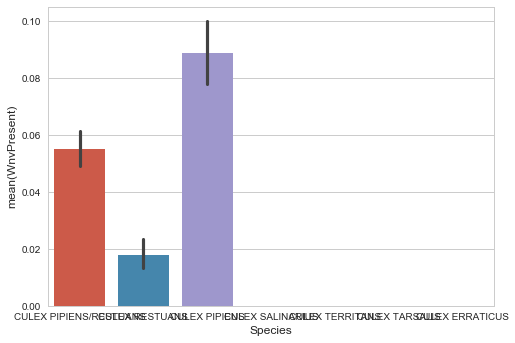

In [117]:
plot_columns = ['Latitude','Longitude','Block','WnvPresent','Date_Number','Species']


temp_df[(temp_df['WnvPresent'] == 1)]

sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="Species", y="WnvPresent", data=temp_df)

In [118]:
##The write_param function saves features to a CSV file where you can manually include or exclude
##Set the variable load_features = True to drop column marked for removal in the CSV file


#######################
generate_new_features = False
#######################

if generate_new_features:
    file_name = p4.write_params(df)
    print(file_name)
    

######################    
load_features = True
#####################    
#Load features
if load_features:
    file_name = 'features_20180612_184917.csv'  #This is an override
    drop_cols = p4.read_params(file_name)
    drop_columns_from_csv(df,drop_cols)
    drop_columns_from_csv(df_test,drop_cols)

   

Inside funct file name features_20180612_184917.csv


In [119]:
##Dummy
df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

#This is a custom function that changes the shape of two dataframs to match
#this is run after get_dummies
dataframe_differences(df,df_test,update_first=True,update_second=False)

#Final assignment of features and target

feature_cols = [col for col in df.columns if not 'WnvPresent' in col]
X = df[feature_cols]
y = df['WnvPresent']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)

print('')
print('')
print('---------------------------------')
print('Train Test Split complete')


Only in first BEFORE: {'WnvPresent'}
Only in second BEFORE: {'Trap_T090B', 'Block_26', 'Trap_T002A', 'Trap_T200A', 'Species_UNSPECIFIED CULEX', 'Trap_T218B', 'Trap_T218A', 'Trap_T090A', 'Trap_T002B', 'Trap_T218C', 'Trap_T200B', 'Trap_T128A', 'Id', 'Trap_T090C', 'Trap_T065A', 'Trap_T234'}
--------------------------------------------
Only in first AFTER: {'WnvPresent'}
Only in second AFTER: set()


---------------------------------
Train Test Split complete


In [120]:
# Let's optimize k-nn for this dataset
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import sklearn.model_selection as cv    # Pel Cross-validation
import sklearn.neighbors as nb          # Per fer servir el knn

# Maximizing Accuracy
params = {'n_neighbors':list(range(1,30,10)), 'weights':('uniform','distance')}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=10,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
clf.fit(X_train, y_train)
print("Best Params=",clf.best_params_, "\nAccuracy on 10-fold cross-validation=", clf.best_score_)
parval=clf.best_params_
knc = nb.KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
knc.fit(X_train, y_train)
pred=knc.predict(X_test)
validation_prediction = knc.predict(df_test)
print("Accuracy on test set:",accuracy_score(y_test, pred))

print("confusion matrix on test set:\n",confusion_matrix(y_test, pred))
print("\n ",classification_report(y_test, pred))

Best Params= {'n_neighbors': 21, 'weights': 'uniform'} 
Accuracy on 10-fold cross-validation= 0.9503671471308132
Accuracy on test set: 0.940989847715736
confusion matrix on test set:
 [[2966    0]
 [ 186    0]]

               precision    recall  f1-score   support

          0       0.94      1.00      0.97      2966
          1       0.00      0.00      0.00       186

avg / total       0.89      0.94      0.91      3152



/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


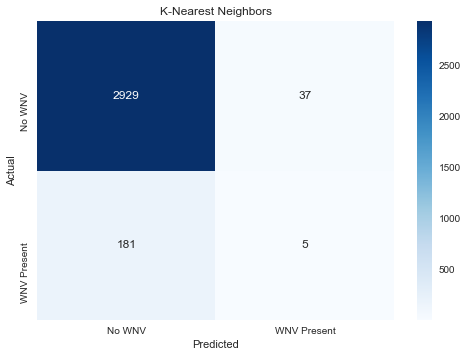

In [121]:
cm = confusion_matrix(y_test, y_pred,labels=None)
sns.set_context(context='notebook', font_scale=1)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt='g',cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('K-Nearest Neighbors')
ax.xaxis.set_ticklabels(['No WNV', 'WNV Present'])
ax.yaxis.set_ticklabels(['WNV Present', 'No WNV'])
plt.show()

Mean cross validation score: 0.9352770603959947


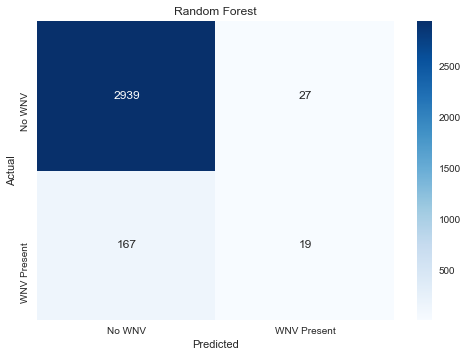

Top 20 most influential features used in the Random Forest Decision Tree


,importance
Date_Number,0.07
Latitude,0.06
Longitude,0.05
ResultSpeed,0.05
AvgSpeed,0.05
Tavg,0.05
Species_CULEX PIPIENS/RESTUANS,0.04
Species_CULEX PIPIENS,0.04
ResultDir,0.04
Tmax,0.04


In [122]:
#Tried Resampling to improve score
########################
resampling = False
########################

rf = RandomForestClassifier(random_state=42,verbose=False)


if resampling:
    print('Resampling applied')
    from collections import Counter
    from imblearn.over_sampling import RandomOverSampler 
    ros = RandomOverSampler(ratio='minority')
    X_train, y_train = ros.fit_sample(X_train, y_train)
    confusion_matrix_title = 'Resampled Minority Random Forest'
    X_train = pd.DataFrame(X_train)
    X_test  = pd.DataFrame(X_test)
    model = rf.fit(X_train,y_train)
else:
    model = rf.fit(X_train,y_train)
    confusion_matrix_title = 'Random Forest'

    
scores = cross_val_score(rf, X_test, y_test)
print('Mean cross validation score:',scores.mean())

y_pred = model.predict(X_test)


feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

cm = confusion_matrix(y_test, y_pred,labels=None)
sns.set_context(context='notebook', font_scale=1)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt='g',cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(confusion_matrix_title)
ax.xaxis.set_ticklabels(['No WNV', 'WNV Present'])
ax.yaxis.set_ticklabels(['WNV Present', 'No WNV'])
plt.show()

print('Top 20 most influential features used in the Random Forest Decision Tree')
round(feature_importances,2).sort_values(by='importance',ascending=False).head(20)

## Prediction with Logistic Regression

Mean cross validation score: 0.9409898358328425


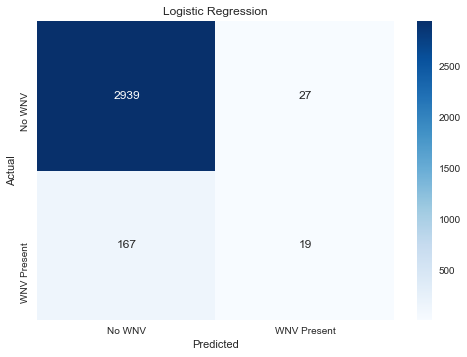

In [123]:
logreg = LogisticRegression(random_state=42,verbose=False)

model = logreg.fit(X_train,y_train)

scores = cross_val_score(logreg, X_test, y_test)
print('Mean cross validation score:',scores.mean())

cm = confusion_matrix(y_test, y_pred,labels=None)
sns.set_context(context='notebook', font_scale=1)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt='g',cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Logistic Regression')
ax.xaxis.set_ticklabels(['No WNV', 'WNV Present'])
ax.yaxis.set_ticklabels(['WNV Present', 'No WNV'])
plt.show()



# CONCLUSION

## These  classifiers performed about the same. 
### 1.  K-Nearest Neighbors
### 2.  Random Forest Classifier
### 3.  Logistic Regression


### Oversampling of minority class produced only a small improvement in prediction 

In [124]:
Model prediction could improve if we had additional features to use for prediction

SyntaxError: invalid syntax (<ipython-input-124-1a3f95b62edd>, line 1)

In [ ]:
# def kag_prep_pjt4(predictions, df, filename):
#     '''Outputs a file with whatever is passed as filename.
#     Intended to be a two column csv.'''
#     df['Id'].map(lambda x: str(x) if type(x) != str else x)
#     preds = pd.DataFrame(predictions)
#     submission = pd.concat([df_test['Id'], preds], axis=1)
#     submission.columns = ["Id", 'WnvPresent']
#     return submission.to_csv(filename, index=False)

In [ ]:
#test_file    = pd.read_csv('../Assets/input/test.csv')
#kag_prep_pjt4(validation_prediction,df_test,'thirdsubmission.csv')